In [1]:
from mle import negative_log_lik, CGMY
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os

In [2]:
np.set_printoptions(precision=4, suppress=False)

In [3]:
DATA_FOLDER = "../data"

In [4]:
def load_returns(path, start_date=None, end_date=None):
    df = pd.read_csv(f"{DATA_FOLDER}/{path}")
    df["Date"] = pd.to_datetime(df["Date"])
    df.index = df["Date"]
    col = "Close" if "Last Price" not in df.columns else "Last Price"
    df = df.filter([col])
    df = df.sort_index()
    if start_date is not None and end_date is not None:
        df = df[(df.index >= start_date) & (df.index <= end_date)]
    rets = np.log(df[col]).diff().dropna()
    return rets

In [ ]:
def load_orderbook_trades(freq):
    """
    Load the trades from the orderbook dataset
    freq : str, the frequency of the data
    """
    path_to_orderbook = f"{DATA_FOLDER}/orderbook"
    files = os.listdir(path_to_orderbook)
    L = []

    # Load the prices for each day
    for file in files:
        if "message" not in file:
            continue

        updates = pd.read_csv(
            f"{path_to_orderbook}/{file}",
            names=["time", "type", "order_id", "volume", "price", "direction", "null"],
            low_memory=False,
        )
        trades = updates[updates["type"] == 4]  # select trades
        trades = trades.reset_index().drop(columns="index")
        base_date = pd.to_datetime(
            file.split("_")[1]
        )  # find the date in the name of the file
        trades["time"] = base_date + pd.to_timedelta(
            trades["time"], unit="s"
        )  # retrieve the correct timstamp
        trades = trades.filter(["time", "price"])
        trades.index = trades["time"]
        trades = trades.sort_index()
        trades_freq = trades.groupby(
            pd.Grouper(key="time", freq=freq) # group by frequency
        ).last()    # select last trade for each frequency

        # create a full range of seconds for the trading day (assuming 9:30–16:00)
        market_open = base_date + pd.Timedelta(hours=9, minutes=30)
        market_close = base_date + pd.Timedelta(hours=16)
        all_seconds = pd.date_range(start=market_open, end=market_close, freq=freq)

        # reindex trades onto full timeline
        trades_full = (
            trades_freq.reindex(all_seconds)  # insert all missing seconds
            .rename_axis("time")
            .reset_index()
        )

        # handle missing prices: leave NaN, or forward-fill if appropriate
        trades_full["price"] = trades_full["price"].ffill()
        L.append(trades_full)
    
    trades = pd.concat(L)  # concatenate all the dates
    trades.index = trades['time']
    trades = trades.sort_index()
    trades["rets"] = np.log(trades["price"]).diff()
    

    return trades["rets"].dropna()

In [50]:
def optim_parall(data, periods=1, seed=123):
    np.random.seed(seed)
    c = np.random.uniform(1e-5, 200)
    g = np.random.uniform(1, 200)
    m = np.random.uniform(1, 200)
    y = np.random.uniform(-5, 1.9)
    sigma = np.random.uniform(1e-5, 0.1)
    res = minimize(
        lambda x: negative_log_lik(x, data, periods),
        x0=[c, g, m, y, sigma],
        bounds=[
            (1e-3, np.inf),
            (1, np.inf),
            (1, np.inf),
            (-5, 1.9),
            (1e-5, 0.1),
        ]
    )
    
    return res

In [7]:
start_date = pd.Timestamp("2021-07-01")
end_date = pd.Timestamp("2025-06-30")

SPX Index Daily

In [26]:
spx_rets_day = load_returns("SPX_D.csv", start_date=start_date, end_date=end_date)

In [27]:
master_seed = 42
rng = np.random.default_rng(master_seed)
seeds = rng.integers(0, 2**32, size=300)
results_spx_day = Parallel(n_jobs=-1)(
    delayed(optim_parall)(spx_rets_day, seed) for seed in seeds
)
mle_spx_day = np.array([np.concat([res.x, [res.fun]]) for res in results_spx_day])

/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(-0.5 * t * (self.sigma * u) ** 2)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res 

In [28]:
np.savetxt("../fits/spx_day.csv", mle_spx_day)

In [29]:
spx_day_best_fits = mle_spx_day[mle_spx_day[:, 5].argsort()]
spx_day_best_fits[:3]


array([[ 2.4364e-02,  9.1404e+01,  8.5719e+01,  6.9263e-01,  1.0000e-05,
        -3.1371e+03],
       [ 1.7452e-01,  1.1953e+02,  1.1346e+02,  3.5132e-01,  1.0000e-05,
        -3.1368e+03],
       [ 1.9700e-01,  1.2115e+02,  1.1551e+02,  3.3043e-01,  1.0000e-05,
        -3.1368e+03]])

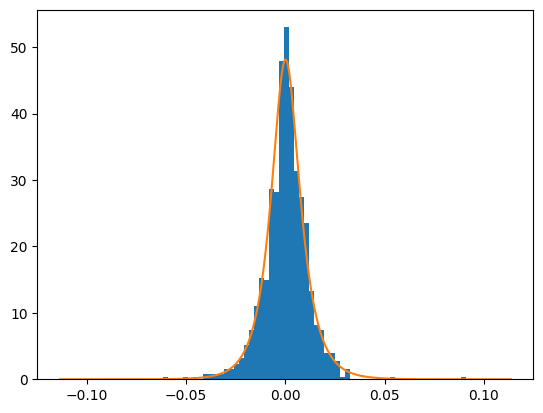

In [133]:
cgmy = CGMY(spx_rets_day, spx_day_best_fits[0][:-1], adjust_L=True)
cgmy2 = CGMY(spx_rets_day, spx_day_best_fits[1][:-1], adjust_L=True)
x, pdf = cgmy.compute_pdf_from_cf()
x2, pdf2 = cgmy.compute_pdf_from_cf()
plt.hist(spx_rets_day, density=True, bins=60)
plt.plot(x, pdf)
#plt.plot(x2, pdf2)

AAPL US Equity Daily

In [11]:
appl_rets_daily = load_returns("AAPL_D.csv", start_date=start_date, end_date=end_date)

In [15]:
master_seed = 42
rng = np.random.default_rng(master_seed)
seeds = rng.integers(0, 2**32, size=300)
results_aapl_day = Parallel(n_jobs=-1)(
    delayed(optim_parall)(appl_rets_daily, seed) for seed in seeds
)
mle_aapl_day = np.array([np.concat([res.x, [res.fun]]) for res in results_aapl_day])


/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(-0.5 * t * (self.sigma * u) ** 2)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:50: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:51: RuntimeWarning: invalid value encountered in multiply
  res 

In [16]:
aapl_day_best_fits = mle_aapl_day[mle_aapl_day[:, 5].argsort()]
aapl_day_best_fits[:10]

array([[ 4.0552e-02,  6.0527e+01,  5.5630e+01,  6.5767e-01,  1.0000e-05,
        -2.6749e+03],
       [ 6.1248e-01,  8.3328e+01,  8.0555e+01,  1.1701e-01,  3.9506e-03,
        -2.6741e+03],
       [ 1.7720e+00,  9.1481e+01,  8.9144e+01, -1.0365e-01,  4.7207e-03,
        -2.6738e+03],
       [ 2.2413e+00,  9.1837e+01,  8.9588e+01, -1.6161e-01,  5.0899e-03,
        -2.6738e+03],
       [ 1.8935e+01,  1.1878e+02,  1.1529e+02, -5.4999e-01,  4.8257e-03,
        -2.6727e+03],
       [ 9.6970e+01,  1.2134e+02,  1.1929e+02, -9.5356e-01,  6.5630e-03,
        -2.6727e+03],
       [ 7.2126e+01,  1.1622e+02,  1.1239e+02, -9.1974e-01,  7.0099e-03,
        -2.6726e+03],
       [ 1.3370e+02,  1.2486e+02,  1.2276e+02, -1.0146e+00,  6.5648e-03,
        -2.6726e+03],
       [ 3.2219e+01,  9.4466e+01,  9.5671e+01, -8.8721e-01,  9.4124e-03,
        -2.6725e+03],
       [ 1.2803e+02,  1.1686e+02,  1.1544e+02, -1.0662e+00,  7.6589e-03,
        -2.6725e+03]])

In [25]:
np.savetxt("../fits/aapl_day.csv", aapl_day_best_fits)

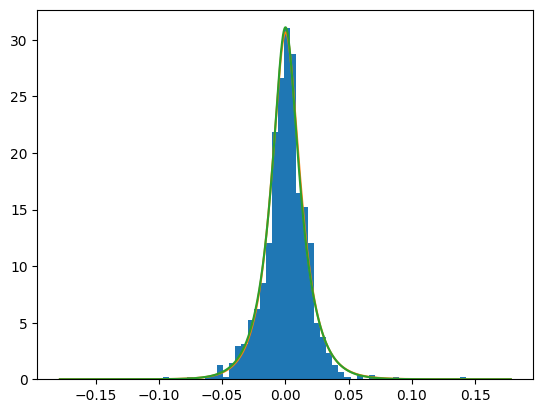

In [32]:
cgmy = CGMY(appl_rets_daily, aapl_day_best_fits[0][:-1], adjust_L=True)
cgmy2 = CGMY(appl_rets_daily, aapl_day_best_fits[1][:-1], adjust_L=True)
x, pdf = cgmy.compute_pdf_from_cf()
x2, pdf2 = cgmy2.compute_pdf_from_cf()
plt.hist(appl_rets_daily, density=True, bins=50)
plt.plot(x, pdf)
plt.plot(x2, pdf2)

AAPL 1S

In [70]:
def mle_orderbook(freq, n=50):
    aapl_freq = load_orderbook_trades(freq)

    master_seed = 42
    rng = np.random.default_rng(master_seed)
    seeds = rng.integers(0, 2**32, size=n)

    results_aapl_freq = Parallel(n_jobs=-1)(
        delayed(optim_parall)(aapl_freq, seed=seed)
        for seed in seeds
    )
    mle_aapl_freq = np.array(
        [np.concat([res.x, [res.fun]]) for res in results_aapl_freq]
    )
    mle_aapl_freq = mle_aapl_freq[mle_aapl_freq[:, 5].argsort()]

    return aapl_freq, mle_aapl_freq


In [ ]:
aapl_1_sec, mle_aapl_1_sec = mle_orderbook("1s")


/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:53: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:54: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:53: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:54: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(
/Users/raphael/Documen

In [82]:
np.savetxt("../fits/aapl_1_s.csv", mle_aapl_1_sec)

In [64]:
mle_aapl_1_sec[:5]

array([[ 1.7083e+04,  9.6345e+03,  1.0076e+04, -1.1343e+00,  1.0000e-05,
        -4.0275e+06],
       [ 1.3594e+02,  7.4230e+03,  1.8713e+03, -7.8911e-01,  1.0000e-05,
        -3.9373e+06],
       [ 2.8458e-03,  1.4329e+02,  1.5107e+04,  3.6026e-01,  1.0000e-05,
        -3.9218e+06],
       [ 1.2372e+01,  9.3615e+02,  6.3356e+03, -5.4692e-01,  1.0000e-05,
        -3.9198e+06],
       [ 5.2574e+00,  9.2232e+02,  1.0733e+04, -4.6058e-01,  1.0000e-05,
        -3.9130e+06]])

AAPL 10 Sec

In [71]:
aapl_10_sec, mle_aapl_10_sec = mle_orderbook("10s")


/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:53: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:54: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:53: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:54: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(
/Users/raphael/Documen

In [72]:
mle_aapl_10_sec[:5]

array([[ 1.0000e-03,  1.4064e+02,  1.6071e+02,  3.9347e-01,  1.7025e-04,
        -3.2575e+05],
       [ 6.5462e+01,  1.9382e+02,  1.8505e+02, -1.6754e+00,  2.1693e-04,
        -3.2327e+05],
       [ 1.5543e+02,  6.1918e+01,  6.5693e+01, -2.5588e+00,  2.2020e-04,
        -3.2315e+05],
       [ 8.8410e+01,  1.4233e+02,  5.3058e+01, -2.4137e+00,  2.2263e-04,
        -3.2312e+05],
       [ 8.4803e+00,  5.6766e+01,  5.0124e+01, -1.8194e+00,  2.2019e-04,
        -3.2311e+05]])

In [73]:
np.savetxt("../fits/aapl_10_s.csv", mle_aapl_10_sec)

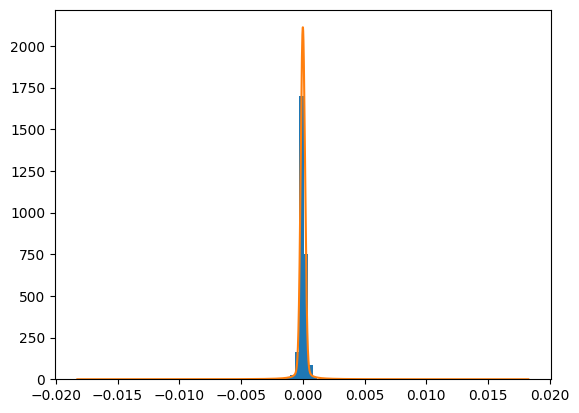

In [74]:
plt.hist(aapl_10_sec, density=True, bins=60)
cgmy = CGMY(aapl_10_sec,  mle_aapl_10_sec[0][:-1], adjust_L=True)
x, pdf = cgmy.compute_pdf_from_cf(t=1)
plt.plot(x, pdf)

30s

In [75]:
aapl_30_sec, mle_aapl_30_sec = mle_orderbook("30s")

In [83]:
np.savetxt("../fits/aapl_30_s.csv", mle_aapl_30_sec)

In [78]:
mle_aapl_30_sec[:5]

array([[ 1.0000e-03,  1.8650e+02,  9.4422e+01,  4.2165e-01,  3.0250e-04,
        -1.0038e+05],
       [ 1.3406e-03,  8.2650e+01,  5.0537e+01,  3.1545e-01,  3.1925e-04,
        -1.0027e+05],
       [ 2.4138e-03,  5.1610e+02,  2.3499e+03,  4.4595e-01,  2.9292e-04,
        -1.0017e+05],
       [ 2.6554e+01,  6.7189e+02,  5.3426e+02, -1.2913e+00,  3.7766e-04,
        -1.0011e+05],
       [ 2.2543e+01,  5.8901e+02,  2.0319e+02, -1.3073e+00,  3.5624e-04,
        -9.9996e+04]])

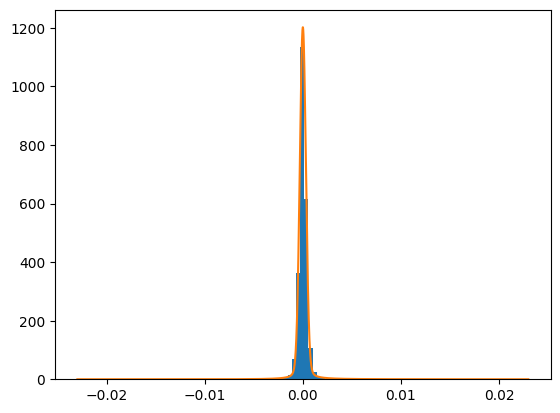

In [80]:
plt.hist(aapl_30_sec, density=True, bins=60)
x, pdf = CGMY(aapl_30_sec,  mle_aapl_30_sec[0][:-1], adjust_L=True).compute_pdf_from_cf()
plt.plot(x, pdf)

60s

In [84]:
aapl_60_sec, mle_aapl_60_sec = mle_orderbook("60s")

/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:53: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:54: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(logits)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:53: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(1j * self.mu * u * t)
/Users/raphael/Documents/cours/Imperial College/thesis/cgmy_estimation/src/mle.py:54: RuntimeWarning: invalid value encountered in multiply
  res *= np.exp(
/Users/raphael/Documen

In [85]:
np.savetxt("../fits/aapl_60_s.csv", mle_aapl_60_sec)

In [86]:
mle_aapl_60_sec[:5]

array([[ 1.0000e-03,  7.8505e+02,  7.0369e+02,  7.3060e-01,  1.5407e-04,
        -4.7806e+04],
       [ 1.0000e-03,  1.2268e+02,  1.2878e+02,  4.7834e-01,  4.0311e-04,
        -4.7678e+04],
       [ 1.4350e-03,  1.8647e+02,  9.3402e+01,  4.4150e-01,  3.8609e-04,
        -4.7666e+04],
       [ 1.2451e-03,  6.0511e+01,  6.6489e+01,  3.9860e-01,  4.1677e-04,
        -4.7619e+04],
       [ 1.2836e+01,  1.4080e+02,  1.6070e+02, -1.3563e+00,  4.9437e-04,
        -4.7396e+04]])

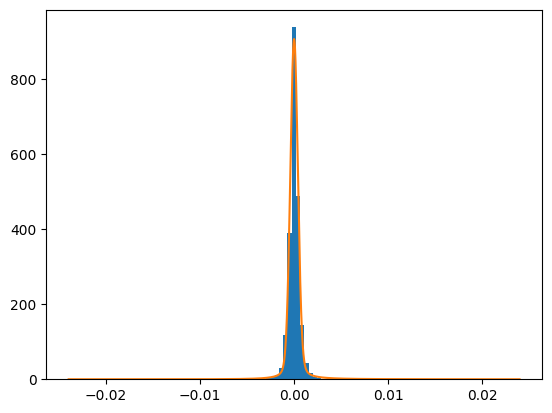

In [87]:
plt.hist(aapl_60_sec, density=True, bins=60)
x, pdf = CGMY(aapl_60_sec,  mle_aapl_60_sec[2][:-1], adjust_L=False).compute_pdf_from_cf()
plt.plot(x, pdf)

5 min

In [88]:
aapl_300_sec, mle_aapl_300_sec = mle_orderbook("300s")

In [89]:
mle_aapl_300_sec[:5]

array([[ 2.4206e+00,  7.6699e+02,  6.1351e+02, -2.2309e-01,  1.0000e-05,
        -8.3931e+03],
       [ 1.0000e-03,  3.5140e+02,  3.4659e+02,  8.4471e-01,  1.0000e-05,
        -8.3356e+03],
       [ 1.2450e-03,  2.8712e+02,  1.8430e+02,  7.1465e-01,  6.4857e-04,
        -8.3255e+03],
       [ 1.0000e-03,  2.8554e+02,  1.8364e+02,  8.2041e-01,  1.0000e-05,
        -8.3225e+03],
       [ 1.6209e+02,  2.8998e+02,  1.9268e+02, -1.6849e+00,  1.1100e-03,
        -8.2914e+03]])

In [90]:
np.savetxt("../fits/aapl_300_s.csv", mle_aapl_300_sec)

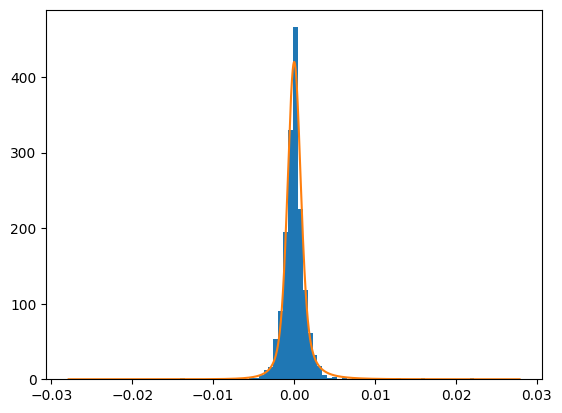

In [93]:
plt.hist(aapl_300_sec, density=True, bins=60)
x, pdf = CGMY(aapl_300_sec,  mle_aapl_300_sec[2][:-1], adjust_L=False).compute_pdf_from_cf()
plt.plot(x, pdf)